In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
import ForwardDiff
import DiffResults
using AstrodynamicsBase
using Printf
using JSON
using CSV
using DataFrames
using ColorSchemes
using LaTeXStrings

In [14]:
include("../src/SailorMoon.jl")   # relative path to main file of module
param3b = SailorMoon.dynamics_parameters()
paramMulti = SailorMoon.multi_shoot_parameters(param3b)
gr()
fs = 16;


┌ Warning: Replacing docs for `Main.SailorMoon.integrate_rk4 :: Union{Tuple{ODEProblem, Real}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool, Bool}}` in module `Main.SailorMoon`
└ @ Base.Docs docs\Docs.jl:240


In [15]:
### PARAMETERS ###################################
# csv file to load the initial solution
filename = "../run/data/opt_0618_maxJCThrust.csv"
# dv_dir function corresponding to the csv file 
dir_func = SailorMoon.dv_EMrotdir_sb1frame
dir_func = SailorMoon.dv_maxJC_dir_sb1frame

n_arc = 5

##################################################

if dir_func == SailorMoon.dv_no_thrust
    τ_ig = 0.0
else 
    τ_ig = 1.0
end

# load initial guess
df = CSV.read(filename, DataFrame; header=0);


In [16]:
p_ = plot(
    size=(700,500), 
    frame_style=:box, aspect_ratio=:equal, grid=0.4, 
    legend=false, 
    xlabel=L"t", ylabel=L"val",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

In [31]:
row = df[end-1,:]
x = collect(row[4:end])
# x = SailorMoon.oldx2newx(x, n_arc)
t_, u_, th_, th_nominal = SailorMoon.x2time_series(x, dir_func, paramMulti, true);
u_array = [u_[:,i] for i in collect(1:size(u_,2))]
t_days = t_ * param3b.tstar / 86400
t_days = t_days .- t_days[end]  # scale it back to days, and set t_LEO = 0 


θm_lpo = x[19+12*paramMulti.n_arc]  
# thrust_param_nomi = [1.0, 0.0, 0.0]
# th_nominal = get_thrust(t_, u_array, thrust_param_nomi, θm_lpo, dir_func)
# th_nominal = hcat(th_nominal...)

2.466807758

In [32]:
# compute JC from state in EMrot
function compute_JC(state::Vector)
    x, y, z = state[1], state[2], state[3]
    vx, vy, vz = state[4], state[5], state[6]
    r13 = norm([x-param3b.mu2, y, z])  # Earth - SC
    r23 = norm([x-param3b.mu1, y, z])  # Moon - SC
    
    U = 1/2*(x^2+y^2) + param3b.mu1 / r13 + param3b.mu2 / r23 
    JC = 2*U - (vx^2 + vy^2 + vz^2)
    
    return JC 
end

compute_JC (generic function with 1 method)

In [33]:
θlpo = x[19+12*paramMulti.n_arc]

u_emrots = []
JC_vec = []

for (i, tnow) in enumerate(t_)
    θm = θlpo - param3b.oml * tnow
    u_sb1   = u_[1:6,i]
    u_emrot = SailorMoon.transform_SunB1_to_EMrot(u_sb1, θm, param3b.oml, param3b.as)
    u_emrots = push!(u_emrots, transpose(u_emrot))    
    jc = SailorMoon.compute_JC(u_emrot)
    push!(JC_vec, jc)
    
end
u_emrots = Array(reshape(hcat(u_emrots...), 6, size(u_emrots,1)));



In [40]:
# plot(t_, JC_vec, ylim=[0,4], xlabel=L"t,s", ylabel=L"JC")

In [41]:
# plot(t_, u_[1,:], xlabel=L"t,s", ylabel=L"x")

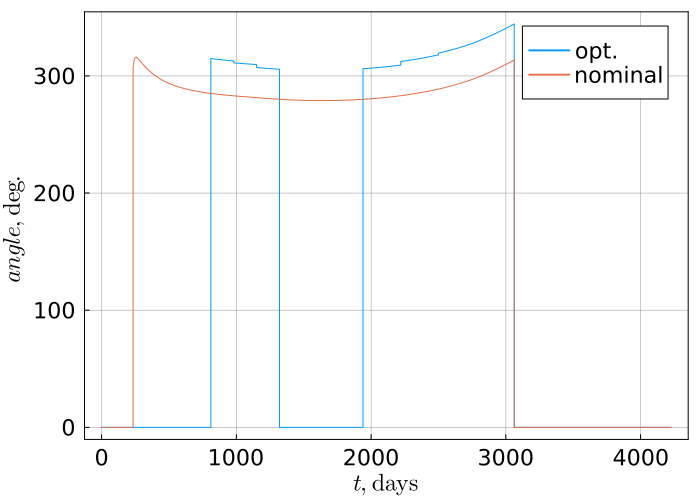

In [39]:
p_thrust = plot(
    size=(700,500), frame_style=:box, grid=0.4, legend=false, 
    xlabel=L"t, \textrm{days}", 
    ylabel=L"angle, \textrm{deg.}",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

angd = atan.(th_[2,:], th_[1,:])
val = [mod2pi(el)/pi*180 for el in angd]


plot!(p_thrust, t_days, val, label="opt.")

angd = atan.(th_nominal[2,:], th_nominal[1,:])
val = [mod2pi(el)/pi*180 for el in angd]

plot!(p_thrust, t_days, val, label="nominal")

plot!(p_thrust, legend=:topright)


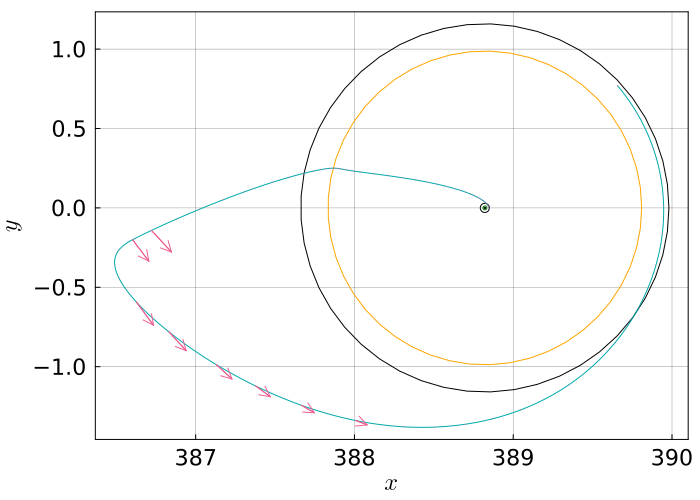

In [13]:
moon     = SailorMoon.plot_circle(1-param3b.mu2, param3b.as , 0.0)
earth    = SailorMoon.plot_circle(param3b.mu2, param3b.as, 0.0)
earth_ub = SailorMoon.plot_circle(param3b.mu2+6375/param3b.lstar, param3b.as, 0.0)
earth_lb = SailorMoon.plot_circle(param3b.mu2-6375/param3b.lstar, param3b.as, 0.0)
moon_soi_outer = SailorMoon.plot_circle(1-param3b.mu2+66000/param3b.lstar, param3b.as, 0.0);


pcart_ = plot(
    size=(700,500), frame_style=:box, aspect_ratio=:equal, grid=0.4, legend=false, 
    xlabel=L"x", 
    ylabel=L"y",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

plot!(pcart_, earth[1,:], earth[2,:], c=:green, lw=1.0, label="earth")
plot!(pcart_, earth_ub[1,:], earth_ub[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart_, earth_lb[1,:], earth_lb[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart_, moon[1,:], moon[2,:], c=:orange, lw=1.0, label="moon")
plot!(pcart_, moon_soi_outer[1,:], moon_soi_outer[2,:], c=:black, lw=1.0, label="moon_soi_outer")
plot!(pcart_,u_[1,:], u_[2,:])

k = size(u_,2)
m = 20
quiver!(pcart_,u_[1,collect(1:m:k)], u_[2,collect(1:m:k)], quiver=(th_[1,collect(1:m:k)]/10, th_[2,collect(1:m:k)]/10))



In [42]:
savefig(p_thrust, "thrust_hist_sample1.png")

"C:\\Users\\yujit\\Documents\\github\\SailorMoon.jl\\tests_yuji\\thrust_hist_sample1.png"